In [1]:
import os
import sys
import warnings

os.chdir("../..")
sys.path.append("../../")
warnings.filterwarnings("ignore")

# Simulate datasets with cell library size

## Introduction

In this example, we will show how to use scDesign3Py to simulate datasets adjusted by cell library size. The purpose of this example is to show that including the library size when modeling the marginal distribution for each gene can help cells in the synthetic data have more similar library sizes as the cells in the real data.

## Import packages and Read in data

### import pacakges

In [2]:
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import scDesign3Py

The R project used is located at /home/ld/anaconda3/envs/pyscdesign/lib/R


### Read in the reference data

The raw data is from the R package `DuoClustering2018` which contain a set of datasets with true cell type labels and converted to `.h5ad` file using the R package `sceasy`.

In [3]:
data = ad.read_h5ad("data/Zhengmix4eq.h5ad")
data.obs["cell_type"] = data.obs["phenoid"]
data.obs["cell_type"] = data.obs["cell_type"].astype("category")

We then calculate the library size for each cell.

In [4]:
sc.pp.calculate_qc_metrics(data,inplace=True)
data.obs.rename(columns={'total_counts':'library'},inplace=True)

In [5]:
data

AnnData object with n_obs × n_vars = 3555 × 1556
    obs: 'barcode', 'phenoid', 'total_features', 'log10_total_features', 'library', 'log10_total_counts', 'pct_counts_top_50_features', 'pct_counts_top_100_features', 'pct_counts_top_200_features', 'pct_counts_top_500_features', 'sizeFactor', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'id', 'symbol', 'mean_counts', 'log10_mean_counts', 'rank_counts', 'n_cells_counts', 'pct_dropout_counts', 'total_counts', 'log10_total_counts', 'n_cells_by_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts'
    obsm: 'X_pca', 'X_tsne'
    layers: 'logcounts', 'normcounts'

## Simulation

Then, we set the mu_formula as cell_type and offsetted by the cell library size to generate new dataset adjusted by library size. The library size is log-transformed because the link function for $\mu$ of the negative binomial distribution in GAMLSS is **log**.

In [6]:
test = scDesign3Py.scDesign3(n_cores=3,parallelization="pbmcmapply")
test.set_r_random_seed(123)
simu_res = test.scdesign3(    
    anndata = data,
    default_assay_name = "counts",
    celltype = "cell_type",
    other_covariates = "library",
    mu_formula = "cell_type + offset(log(library))",
    sigma_formula = "1",
    family_use = "nb",
    usebam = False,
    corr_formula = "1",
    copula = "gaussian",
    important_feature = "auto")

R[write to console]: Input Data Construction Start

R[write to console]: Input Data Construction End

R[write to console]: Start Marginal Fitting



  |=======================================================| 100%, Elapsed 06:12


R[write to console]: Marginal Fitting End

R[write to console]: Start Copula Fitting

R[write to console]: Convert Residuals to Multivariate Gaussian



  |=======================================================| 100%, Elapsed 01:50


R[write to console]: Converting End

R[write to console]: Copula group 1 starts

R[write to console]: Copula Fitting End

R[write to console]: Start Parameter Extraction



  |=======================================================| 100%, Elapsed 02:57


R[write to console]: Parameter
Extraction End

R[write to console]: Start Generate New Data

R[write to console]: Use Copula to sample a multivariate quantile matrix

R[write to console]: Sample Copula group 1 starts



  |=======================================================| 100%, Elapsed 00:06


R[write to console]: New Data Generating End



Then we can construct new data using the simulated count matrix.

In [7]:
simu_data = ad.AnnData(X=simu_res["new_count"], obs=simu_res["new_covariate"])
simu_data.layers["log_transformed"] = np.log1p(simu_data.X)
data.layers["log_transformed"] = np.log1p(data.X)

## Visualization

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

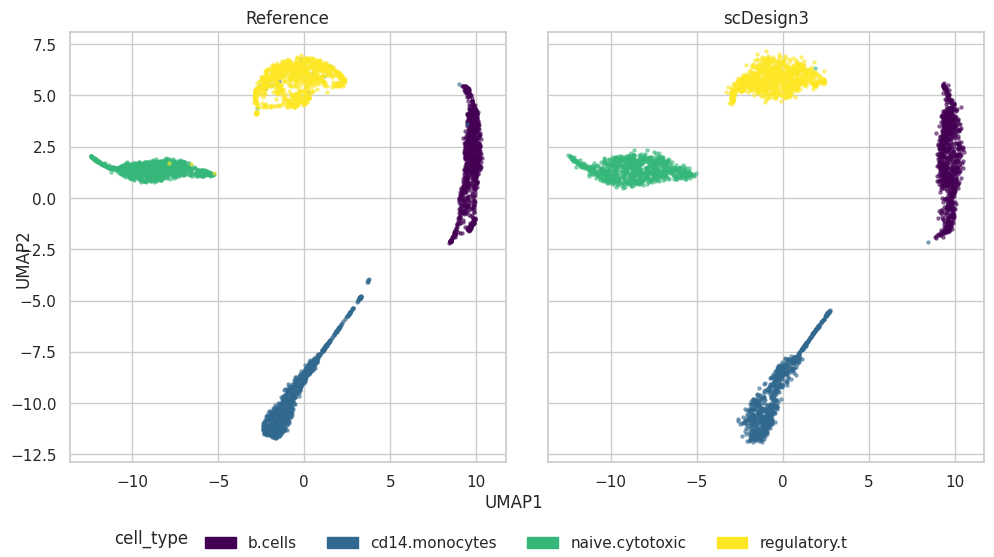

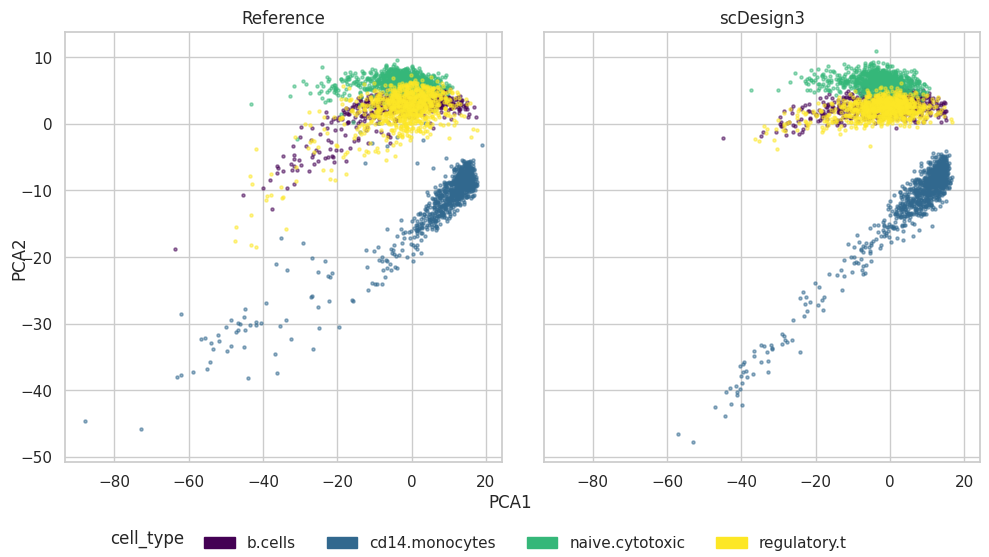

In [9]:
plot = scDesign3Py.plot_reduceddim(
    ref_anndata=data,
    anndata_list=simu_data,
    name_list=["Reference", "scDesign3"],
    assay_use="log_transformed",
    if_plot=True,
    color_by="cell_type",
    n_pc=20,
    point_size=5,
)

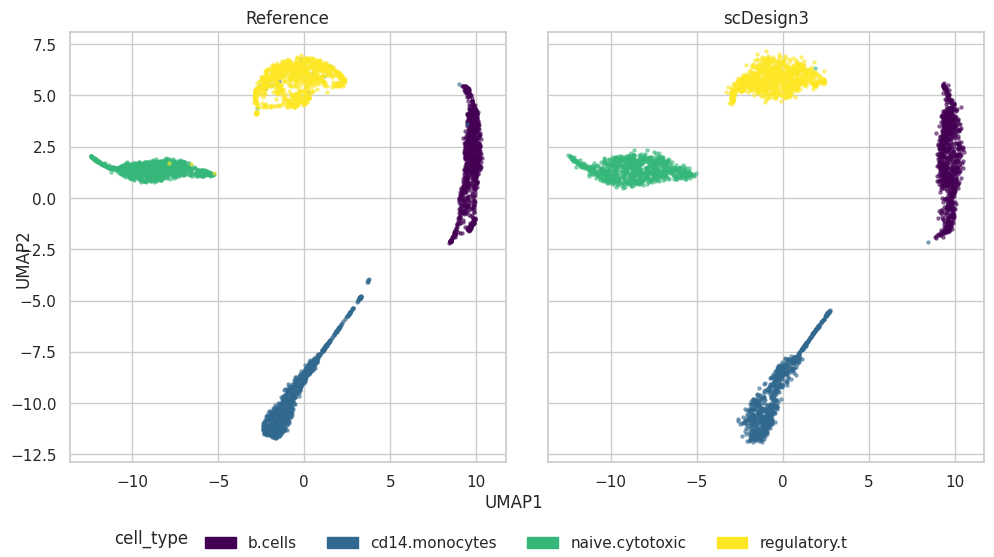

In [10]:
plot["p_umap"]

The violin plot below shows the cells in simulated dataset have similar library size as the cells in the reference dataset.

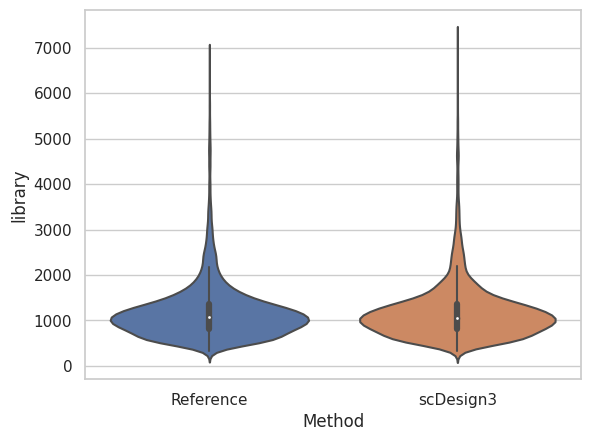

In [11]:
sc.pp.calculate_qc_metrics(simu_data,inplace=True)
simu_data.obs.rename(columns={'total_counts':'simu_library'},inplace=True)
df = pd.concat([data.obs["library"],simu_data.obs["simu_library"]],axis=1)

# plot
sns.violinplot(df)
plt.xlabel("Method")
plt.ylabel("library")
plt.xticks(ticks = [0, 1], labels = ["Reference","scDesign3"])
plt.show()